*This notebook is a work in progress. Please send notes, comments and other suggestions to [olafur.bogason@mail.mcgill.ca](olafur.bogason@mail.mcgill.ca)*

When starting out Wave Digital Filters (WDFs) can seem cryptic and implementing them time consuming to say the least. In this notebook I hope to shed some light on WDFs and how they work out in practice. This is not a review article on current research trends. This is an article I wish I had read when I started to dabble with the theory.

# Wave Digital Filters

Wave Digital Filters were first mentioned in a German patent filed in the late 1960s by Alfred Fettweis. Originally they were used to discretize RCL ladder circuits, that is circuits that can be decomposed into a cascade of series and parallel connections. WDFs can be seen as a [finite difference scheme](https://en.wikipedia.org/wiki/Finite_difference_method) with some nice numerical properties. WDFs allow an audio DSP designer to create algorithms that are *physically informed*. That is, algorithms that retain underlying structure (topology) of a reference circuit and use physical approximations, traditionally [a lumped model](https://en.wikipedia.org/wiki/Lumped_element_model), of how circuit components behave. 

The Wave part of Wave Digital Filters is a reference to the fact that the independent variables in the WD-domain are so called wave-variables (which all EE engineers know from [Two-port networks](https://en.wikipedia.org/wiki/two-port_network)). Having waves as independent variables allows the use of concepts such as [scattering](https://en.wikipedia.org/wiki/Scattering) and [impedence matching](https://en.wikipedia.org/wiki/Impedance_matching).

For each lumped element in the Kirchoff/K-domain there exists a *port* in the Wave Digital/WD-domain. Similarly for series and parallel connections in the K-domain there exist series and parallel *adaptors* in the WD-domain. Many circuits in the wild however cannot be split into a cascade of series and parallel adaptors.

That means that the scope of circuits that were tractable via WDF was very limited. Recently researchers have found a way to use WDFs to cover [arbitrary topologies](http://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_53.pdf). This method proposed to use of [Modified Nodal Analysis](https://en.wikipedia.org/wiki/Modified_nodal_analysis) along with some clever linear algebra tricks to describe the scattering behaviour of a multi-port R-type (Rigid) adaptor.

---

Examples on how to implement WD-structures will be given in Python code. The reason for choosing Python is that it is an interpreted language and its simplicity allows me to concentrate on the explanation of WD concepts rather than the programming itself. There is a nice real-time C++ library being developed [here](https://github.com/RT-WDF/rt-wdf_lib).

To keep things simple, classes are used to handle individual WD ports. Simple functions are used for adaptors to show how the computation is done. Instead of displaying all the code at once, snippets are interleaved with the text. Results from simulations of WD structures are compared to results obtained by simulating the same circuits in [LTspice](http://www.linear.com/designtools/software/).

In [325]:
%matplotlib inline

# Some auxillary code.
import numpy as np
import pandas as pd
from scipy import signal
from sympy import *
import matplotlib.pyplot as plt

FS = 96e3  # Sample frequency.  
N = 2**14  # Number of points to simulate.

input = np.zeros(N)
input[0] = 1  # Input is a delta function.
output = np.zeros(input.size)
steps  = np.arange(N)

# Make legends nicer and find best location for box.
legend_style = {"loc":0, "frameon":False, "fontsize":10}

def plot_freqz(x, title="Frequency response"):
    # Plot the frequency response of a signal x.
    ax = plt.subplot(111)
    w, h = signal.freqz(x, 1, 2048*2)
    H = 20 * np.log10(np.abs(h))
    f = w / (2 * np.pi) * FS
    # Make plot pretty.
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.semilogx(f, H, label="WDF")
    plt.xlim([np.min(f), np.max(f)])
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')

def plot_ltspice_freqz(filename, title="Frequency response", out_label='V(vout)'):
    # Plot the frequency responce of a LTspice simulation containing
    # frequency and complex signal.
    def imag_to_mag(z):
        # Returns the maginude of an imaginary number.
        a, b = map(float, z.split(','))
        return 20*np.log10(np.sqrt(a*a + b*b))
    
    x = pd.read_csv(filename, delim_whitespace=True)
    x['H_dB'] = x[out_label].apply(imag_to_mag)

    f = np.array(x['Freq.'])
    H_db = np.array(x['H_dB'])
    plt.semilogx(f, H_db, label="LTspice")


# WD-domain variables
One-port elements in electrical circuits include components such as resistors, capacitors and inductors. They also include ideal and resistive voltage and current sources along with short and open circuits. Many more one-port elements exist, but those are some of the elements that have already been ported over to the WD-domain and are used in practice. 

K-domain variables $v$ and $i$ are linearly mapped to WD-domain variables $a$ and $b$ with the following linear transforms:

\begin{align}
a &= v + i \cdot R_p \\ 
b &= v - i \cdot R_p 
\end{align}

\begin{align}
v &= \frac{1}{2}(a + b) \\ 
i &= \frac{1}{2 R_p}(a - b)
\end{align}

$R_p$ is called a **port resistance**. It is physically introduced into the system, meaning that in practice it can be set to any real value.

![](files/images/port.png)
The picture above catches the most important variables in one place. We have the instantaneous Thévenin port equivalence circuit ($v_s$, $R_s$) along with independent variables in K-domain, $V$, $i$ and in the WD-domain $a$, $b$ and the port resistance $R_p$.

# Discretization of dynamic elements

An integral part of coming up with a WDF structure is to digitize the reactive components in the reference circuit. Although most text out there will only mention the use of biliear transform to digitze circuits, it is by no means the only way. There are even certain cases where using it may render the [WD simulation unstable](https://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_52.pdf). For our case we will still use it for the sake of its simplicity.

\begin{align}
s & \leftarrow \frac{1}{2 f_s} \frac{z - 1}{z + 1}
\end{align}

There is one thing to keep in mind during the following derivations. For the resulting WDF structure to be computable we cannot have any delay-free loops inside it. That means that for each one-port element we are looking for a function $f$ that maps $a$ -> $b$ but $b_t$ cannot depend on $a_t$. It can only on delayed versions of $a$, e.g. $a_{t-1}$.

To deal with this issue we have two theoretical tools at our disposal: (a) the port resistance, (b) adapt a port of an adaptor by using the concept of scattering. Adapting a port or making it reflection free means that we choose the port resistance at that port so that the reflected wave does not depend directly on the incident wave at that same port. Note that the reflected wave can, and often will, depend on incident waves from other ports of the same adaptor.

# One port elements
Starting with the K-domain representaion of a one-port element it is is simple to derive the most common one-port elements. The linear mappings between the K- and WD-domain are used extensively in this part.

In [306]:
class WDFOnePort(object):
    def __init__(self):
        # Incident- and reflected wave variables.
        self.a, self.b = 0, 0
        
    def wave_to_voltage(self):
        voltage = (self.a + self.b) / 2
        # print(voltage)
        return voltage

    def wave_to_current(self):
        current = (1 / 2 * self.Rp) * (self.a + self.b)
        # print(current)
        return current

### WDF Resistor
\begin{align}
Z_R = R &= \frac{v}{i} \\
    &= \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)}
\end{align}

$$ b = \frac{R - R_p}{R + R_p} a $$

If we write that out with explicit time we get:

$$ b[n] = \frac{R - R_p}{R + R_p} a[n] $$

so we see that the reflected wave depends instantaneously on the incident wave: We have a delay-free loop. To break that loop we must use our free parameter and set $R_p = R$. That choice causes $Z_R = 0$ and $b = 0$ for all resistor elements. In other words it means that the reflected wave is always zero independent on the value of inciding wave! But what does that really mean? Will resistors not contribute at all to the WDF structure? 

Far from it. Because we set the port resistance equal to the physical resistance of resitors they directly contribute to the scattering of incident waves at the adaptor connected to any given resistor. More about that later. 

![](files/images/resistor.png)

In [307]:
class Resistor(WDFOnePort):
    def __init__(self, R):
        WDFOnePort.__init__(self)
        self.Rp = R  # Port resistence set to physical resistance
    
    def get_reflected_wave(self, a):
        self.a = a
        self.b = 0
        return self.b

### WDF Capacitor
Now we move on to reactive elements. and describe the capacitor as a function of the Laplace variable $s$.

\begin{align}
Z_C = \frac{1}{sC} & = \frac{v}{i} \\
                   & = \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)}
\end{align}

$$ b = S a = \frac{1 - R_p C s}{1 + R_p C s} a $$

The bilinear transform is used to digitize the function $S$ 

\begin{align}
b = S a & = \frac{1 - R_p C \frac{1}{2 f_s} \frac{z - 1}{z + 1}}{1 + R_p C \frac{1}{2 f_s} \frac{z - 1}{z + 1}} a \\
        & = \frac{(1 - 2 f_s C R_p) + (1 +  2 f_s C R_p)z^{-1}}{(1 + 2 f_s C R_p) + (1 -  2 f_s C R_p)z^{-1}} a 
\end{align}

If we transform that into the time-domain we have the following difference equation.

\begin{align}
b[n] = & = \frac{1}{1 + 2 f_s C R_p} \left ( (1 - 2 f_s C R_p) a[n] + (1 + 2 f_s C R_p) a[n-1] - (1 - 2 f_s C R_p) b[n -1]) \right )
\end{align}


Again we have a delay-free loop which we must break up. The only way for that to be achieved is if $R_p = \frac{1}{2f_sC}$. Then the reflected wave is $ b = z^{-1} a $. That is, the reflected wave is simply a unit-delayed version of the incident wave. This result is of course different for other methods of discretization.

![](files/images/capacitor.png)

-4.599961204188532e-07
3.0400038795811467e-06


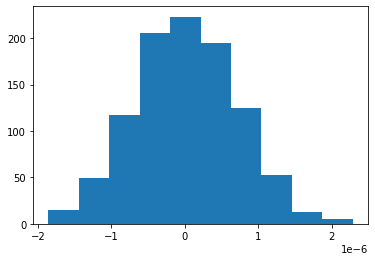

In [308]:
# import np.random
C = 3.5e-6
tol = .2
gd = np.random.normal(0,tol*C,1000)
plt.hist(gd)
s = np.random.choice(gd)
print(s)
print(C+s)

4.947580261211061e-07


Text(0, 0.5, 'occurrences')

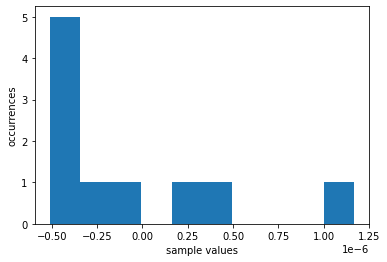

In [309]:
import scipy.stats as stats

class Capacitor(WDFOnePort):
    def __init__(self, C, tolerance=.2,sSize=10):
        WDFOnePort.__init__(self)
        
        # self.C = C
        # self.Rp = 1 / (2 * FS * self.C)
        # self.tol = tolerance
        # create wave table to alter capacitance, amplitude and freq deetermined by tolerance and tolFreq
        # n = np.arange(0,1,1/FS)
        # x = np.cos(2 * np.pi * tolFreq * n) * (self.tol * self.C)
        # self.tolTable = x

        # gaussian distribution of vals below and above given C
        # according to tolerance 
        # sample is selected and added to given capacitance value
        self.tol = tolerance
        self.data_normal = stats.norm.rvs(size = sSize,loc = 0, scale = C * self.tol / 2)
        rand_samp = np.random.choice(self.data_normal)
        self.C = C + rand_samp        
        self.Rp = 1 / (2 * FS * self.C)

    def get_reflected_wave(self, a):
        self.b = self.a
        self.a = a
        return self.b
    
    def set_incident_wave(self, a):
        self.a = a

    # def updateRp(self,i):
    #     # print(self.tolTable[i%len(self.tolTable)])
    #     self.C += self.tolTable[i%len(self.tolTable)]
    #     self.Rp = 1 / (2 * FS * self.C)


c = Capacitor(5e-6)
max(c.data_normal)
print(abs(5e-6-c.C))
plt.hist(c.data_normal)
plt.xlabel('sample values')
plt.ylabel('occurrences')
# print(len(c.tolTable))
# plt.plot(c.tolTable[:500])
# N = stats.norm(loc=0, scale=.1)
# r = N.rvs(1000)
# print(np.where(r==0))
# print(r)


### WDF Inductor
Following the same approach as above we can easilly derive the WD-domain representation for an inductor.

\begin{align}
Z_L = sL & = \frac{v}{i} \\
         & = \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)} 
\end{align}

$$ b = S a = \frac{sL - R_p}{sL + R_p} a $$

Now we use the bilinear transform and digitize S. 

\begin{align}
b = S a & = \frac{\frac{1}{2 f_s} \frac{z - 1}{z + 1}L - R_p}{\frac{1}{2 f_s} \frac{z - 1}{z + 1}L + R_p} a \\
        & = \frac{(2f_sL - R_p) - (2f_sL + R_p)z^{-1}}{(2f_sL + R_p) + (2f_sL - R_p)z^{-1}} a 
\end{align}

Here as well we have a delay-free loop that we can break up by setting $R_p = 2 f_s L$. Plugging that result into the equation above we get that $b = - z^{-1} a$, which means that the reflected wave is a unit-delayed inciding wave with phase inverted.

![](files/images/inductor.png)

In [310]:
class Inductor(WDFOnePort):
    def __init__(self, L):
        WDFOnePort.__init__(self)
        self.Rp = (2 * FS * L)
    
    def get_reflected_wave(self, a):
        self.b = self.a
        self.a = a
        return -self.b
    
    def set_incident_wave(self, a):
        self.a = a

In [311]:

def omega3(x):
    x1 =  -3.341459552768620
    x2 = 8.0
    a =  -1.314293149877800e-3
    b = 4.775931364975583e-2
    c = 3.631952663804445e-1
    d = 6.313183464296682e-1
    if x < x1:
        return 0
    elif x < x2:
        return d + x * (c + x * (b + x * a))
    return x - np.log(x)

class Diode(WDFOnePort):
    def __init__(self,Rp):
        WDFOnePort.__init__(self)
        self.Rp = Rp
        self.Vt = 25.85e-3
        self.Is = 0
    
    def set_incident_wave(self,a):
        self.a = a

    def get_reflected_wave(self,a):
        lam = np.sign(a)
        R_Is_overVT = self.Rp * self.Is * (1 / self.Vt)
        logR_Is_overVT = np.log(R_Is_overVT)
        lam_a_overVT = lam * self.a / self.Vt
        self.b = self.a - (2 * self.Vt) * lam * (omega3(logR_Is_overVT + lam_a_overVT)) - omega3(logR_Is_overVT - lam_a_overVT)
        # self.b  = self.a - 2 * lam * self.Rp * self.wave_to_current() - 2 * self.Vt * omega3(np.log(self.Rp * self.wave_to_current() / self.Vt) + self.a * 1 / self.Vt + self.Rp * self.wave_to_current() / self.Vt)
        return self.b

### Short circuit
A short circuit can be seen as a resistor with no resistance, that is $R = 0$.

$$ b = \frac{R - R_p}{R + R_p} a = -a$$

That results essentially tells us that the inciding wave gets completely projected back through the port, with a change in phase. 

We see that in this case the reflected wave depends instantaneously on the incident wave. If we want the resulting WDF structure to be computable we cannot have that. Fortunately the port resistance may be tuned so that the incident wave coming from the port will in fact be zero. That way the reflected wave is also always zero.

![](files/images/short.png)

In [312]:
class ShortCircuit(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
    
    def get_reflected_wave(self, a):
        self.a = a
        self.b = -a
        return self.b

### Open circuit
A short circuit can most easilly be seen as a resistor with infinite resitance, that is $R \rightarrow \infty$

\begin{align}
b & = \frac{R - R_p}{R + R_p} a \\
  & = \frac{1 - R_p/R}{1 + R_p/R} a  \\
  & = a
\end{align}

The difference between a short- and open circuit is the additional minus sign, which stands for a 180 degree change in phase.

![](files/images/open.png)

In [313]:
class OpenCircuit(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
    
    def get_reflected_wave(self, a):
        self.a = a
        self.b = a
        return self.b

### Switch
Building a simple on/off switch from the last two one-port elements is fairly simple. The only additional thing needed is a variable that holds the port's internal *state*.

In [314]:
class Switch(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
        __state = False 
    
    def get_reflected_wave(self, a):
        if __state: # Switch closed
            self.a = a
            self.b = -a
        else:       # Switch open
            self.a = a
            self.b = a
            
        return self.b
    
    def change_state(self, state):
        __state = state

### Ideal Voltage Source
Deriving the WD equivalent of an ideal voltage source with voltage $v_s$ is straight forward.

\begin{align}
v = v_s & = \frac{1}{2}(a + b) \\ 
      b & = 2v_s - a 
\end{align}

where $R_p$ is the port resistance and must be matched to the remaining WD structure. Matching or adapting a port is a concept that we will cover in the next section and is used when the port resistance alone cannot be used to break up delay-free loops like we have above.

![](files/images/ideal_volt.png)

In [315]:
class IdealVoltageSource(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
        
    def get_reflected_wave(self, a, vs=0):
        self.a = a
        self.b = 2*vs - a
        return self.b

### Ideal Current Source
The same is possible for an ideal current source with source current $i_s$

\begin{align}
v & = \frac{1}{2 R_p}(a - b) \\ 
b & = a - 2 R_p i_s
\end{align}

Again, to make the structure computable, we have to adapt the port of the adaptor that a WD ideal current source is connected to.

![](files/images/ideal_current.png)

In [316]:
class IdealCurrentSource(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
        
    def get_reflected_wave(self, a, i_s=0):
        self.a = a
        self.b = a - 2*R_p*i_s
        return self.b

### Resistive Voltage Source
An ideal voltage source with voltage $v_s$ connected in series with a resistor R will give us a linear resistive voltage source. Kirchoff's voltage law gives:

\begin{align}
v & = v_s + R_s i \\ 
b & = 2v - a \\ 
  & = 2(v_s + R_s i) - a \\
  & = 2v_s + \frac{2 R_s}{2R_p}(a - b) - a
\end{align}

We can see that again we have a delay-free loop. If $R_p = R_s$ is chosen to be the port resistance then the reflected wave is

$$ b = v_s $$ 

![](files/images/resistive_volt.png)

In [317]:
class ResistiveVoltageSource(WDFOnePort):
    def __init__(self, Rs):
        WDFOnePort.__init__(self)
        self.Rp = Rs
    
    def get_reflected_wave(self, a, v_s=0):
        self.a = a
        self.b = v_s
        return self.b

### Resistive Current Source
A resistive current source is essentially an ideal current source with source current $i_s$ connected in parallel with a resistor $R$. The voltage over the resistor is quantified by $v = (i - i_s)R$ where $i$ is the current flowing into the port. We now have:

\begin{align}
b & = a - 2 R_p i \\ 
  & = a - 2 R_p \frac{v}{R_s} + i_s R_p \\ 
  & = a - \frac{R_p}{R_s}(a + b) + 2 i_s R_p 
\end{align}

Again if we choose to have $R_p = R_s$ then we can break up the delay-free loop and obtain the following equation:

$$ b = R_s i_s $$

![](files/images/resistive_current.png)

In [318]:
class ResistiveCurrentSource(WDFOnePort):
    def __init__(self, R):
        WDFOnePort.__init__(self)
        self.Rp = R
    
    def get_reflected_wave(self, a, i_s=0):
        self.a = a
        self.b = self.Rp*i_s
        return self.b

# Adaptors
Now that we have a couple of one port elements laid out we need a way to connect them together. Historically circuits that have been simulated using WDFs have been connected in some seperable series and/or parallel conjunction. That is why we start by deriving series and parallel adaptors.

### Two-port simple adaptors
#### Series
Two port series adaptors are described by the following two equations:

\begin{align}
0   & = v_1 + v_2 \\ 
i_1 & = i_2 = i_J
\end{align}

where $i_J$ is the current flowing into the junction.

\begin{align}
0   & = v_1 + v_2 = \frac{1}{2}(a_1 + b_1) + \frac{1}{2}(a_2 + b_2) \\ 
b_1 & = \underline{-(a_2 + a_1) - b_2}
\end{align}

\begin{align}
0 & = i_2 - i_1 = \frac{1}{2R_2}(a_2 - b_2) - \frac{1}{2R_1}(a_1 - b_1) \\ 
  & = a_2 - b_2 - \frac{R_2}{R_1}(a_1 - b_1) \\
b_2 & = \frac{R_1 - R_2}{R_1 + R_2}a_2 - \frac{2R_2}{R_1 + R_2}a_1 \\
    & = \underline{-a_1 + \gamma(a_1 + a_2)}
\end{align}

where $\gamma = \frac{R_1 - R_2}{R_1 + R_2}$ is the [reflection coefficient](https://en.wikipedia.org/wiki/Reflection_coefficient) with a negative sign. Now we can get the reflected wave at port 1.

\begin{align}
b_1 & = -a_2 + \gamma(a_1 + a_2) \\
b_2 & = -a_1 + \gamma(a_1 + a_2)
\end{align}

![](files/images/series_2port.png)

#### Parallel
We can derive the scattering relationship for parallel adaptors in a similar fashion. Conversely to the series adaptor the currents in the parallel adaptor sum up to zero but the voltages are all equal.

\begin{align}
0   & = i_1 + i_2 \\ 
v_1 & = v_2 = v_J 
\end{align}

where $v_J$ is defined as the voltage at the junction. Now we can use the definition of the wave variables and derive the relationship of reflected waves to the incident ones:

\begin{align}
0   & = i_1 + i_2 \\
    & = \frac{1}{2R_1}(a_1 - b_1) +  \frac{1}{2R_2}(a_2 - b_2) \\
    & = R_2(a_1 - b_1) + R_1(a_2 - b_2) \\ 
b_1 & = a_1 + \frac{R_1}{R_2}a_2 - \frac{R_1}{R_2}b_2 
\end{align}

Next we use the voltage relationship for series adaptors.

\begin{align}
0 & = v_2 - v_1 = \frac{1}{2}(a_2 + b_2) - \frac{1}{2}(a_1 + b_1) \\
  & = -a_1 + a_2 \frac{R_2 - R_1}{2 R_2} + b_2 \frac{R_2 + R_1}{2 R_2} \\ 
b_2 & = \frac{2 R_2}{R_1 + R_2} a_1 - \frac{-R_1 + R_2}{R_1 + R_2} a_2\\
    & = \underline{a_1 + \gamma (a_2 - a_1)}
\end{align}


\begin{align}
b_1 & = a_1 + \frac{R_1}{R_2}a_2 - \frac{R_1}{R_2}b_2 \\ 
    & = a_1(1 - \frac{2 R_1}{R_1 + R_2}) + a_2(\frac{R_1}{R_2} - \frac{R_1}{R_2}\frac{R_1 - R_2}{R_1 + R_2}) \\ 
    & = \underline{a_2 + \gamma(a_2 - a_1)}
\end{align}

Which boils down to.


\begin{align}
b_1 & = a_2 + \gamma(a_2 - a_1) \\ 
b_2 & = a_1 + \gamma (a_2 - a_1)
\end{align}

![](files/images/parallel_2port.png)

---

Putting it together in vector format further shows us that we have a scattering matrix in 2D space. In the case of a parallel adaptor we have:

\begin{equation}
\begin{matrix}\begin{pmatrix}b_1 \\ b_2 \end{pmatrix} \end{matrix}
\begin{pmatrix} -\gamma & 1 + \gamma \\ 1 - \gamma & \gamma \end{pmatrix}
\begin{matrix}\begin{pmatrix}a_1 \\ a_2 \end{pmatrix} \end{matrix}
\end{equation}

And for the series adaptor we have:

\begin{equation}
\begin{matrix}\begin{pmatrix}b_1 \\ b_2 \end{pmatrix} \end{matrix} =
\begin{pmatrix} \gamma & 1 - \gamma \\ 1 - \gamma & \gamma \end{pmatrix}
\begin{matrix}\begin{pmatrix}a_1 \\ a_2 \end{pmatrix} \end{matrix}
\end{equation}

In [319]:
def parallel_adaptor2(a1, Rp1, a2, Rp2):
    gamma = (Rp1 - Rp2) / (Rp1 + Rp2)
    S = np.array(((-gamma, 1+gamma), (1-gamma, gamma)))
    b1, b2 = np.dot(S, np.array((a1, a2)))
    
    return b1, b2

def series_adaptor2(a1, Rp1, a2, Rp2):
    gamma = (Rp1 - Rp2) / (Rp1 + Rp2)
    S = np.array(((gamma, 1-gamma), (1-gamma, gamma)))
    b1, b2 = np.dot(S, np.array((a1, a2)))
    
    return b1, b2

### N-port adaptors
Although N-port simple adaptors can always be broken up into 2- and 3-port adaptors we will still carry out the derivation for a variable N-port adaptors.

#### Series
As in the case of a 2-port series adaptor the adaptor is described by voltages and currents at each port.

\begin{align}
0   & = v_1 + v_2 + \dots + v_N \\ 
i_1 & = i_2 = \dots = i_N
\end{align}

So now we can start working...

\begin{align}
0 & = v_1 + v_2 + \dots + v_N = (a_1 - R_1 i_1) + (a_2 - R_2 i_2) + \dots + (a_N - R_N i_N) \\  
  & = a_1 + a_2 + \dots + a_N - i \cdot (R_1 + R_2 + \dots + R_N) \\
i   & = i_i = \frac{1}{2 R_i}(a_i - b_i) = \frac{1}{R_1 + R_2 + \dots + R_N}(a_1 + a_2 + \dots + a_N) \\ 
b_i & = a_i - \frac{2 R_i}{R_1 + R_2 + \dots + R_N}(a_1 + a_2 + \dots + a_N)
\end{align}


#### Parallel
To save space and simplify calculations I put $G_i = \frac{1}{R_i}$. The same equations as for the 2-port parallel adaptor apply, only extended to the N-port case.

\begin{align}
0   & = i_1 + i_2 + \dots + i_N \\ 
v_1 & = v_2 = \dots = v_N = v
\end{align}

Which can be used to find a relationship between incident and reflected waves.

\begin{align}
0 & = i_1 + i_2 + \dots + i_N = G_1(a_1 - v) + G_2(a_2 - v) + \dots + G_N(a_N - v) \\
v & = v_i =  \frac{1}{2}(a_i + b_i) = \frac{1}{G_1 + G_2 + \dots + G_N}(G_1 a_1 + G_2 a_2 + \dots + G_N a_N) 
\end{align}

The algebra now places out in the following way

\begin{align}
b_i & = \frac{2}{G_1 + G_2 + \dots + G_N}(G_1 a_1 + G_2 a_2 + \dots + G_N a_N) - a_i \\
    & =  \gamma_1 a_1 + \gamma_2 a_2 + \dots + \gamma_N a_N - a_i
\end{align}

where $\gamma_i$ is traditionally defined as

$$ \gamma_i = \frac{2 \cdot G_i}{G_1 + G_2 + \dots + G_N} $$


#### Example of 3-port adaptors
![](files/images/series_3port.png)


![](files/images/parallel_3port.png)

---
## Adapting adaptor ports
When connecting two adaptors together a question rises. Which port resistance should we choose? The answer is simple. Take the port which is farther away from the root of the resulting SPQR tree and [match the impedence](https://en.wikipedia.org/wiki/Impedance_matching) of the port facing root to the other ports of the adaptors. The matching is dependent on the type of adaptor you have. For series adaptors you sum up the resitances and for parallel adaptors you sum the conductances and inverse them.

### Examples
Say you have a 3-port series adaptor and would like to adapt port 1. Then the port resistance there becomes

\begin{align}
R_1 &= R_2 + R_3
\end{align}

and the reflected wave at that port thus $b_1 = -a_2 - a_3$.

The same procedure applied for a 3-port parallel adaptor. The port resistance at port 1 becomes:

\begin{align}
R_1 &= \frac{1}{1/R_2 + 1/R_3}
\end{align}

and the reflected wave is then

\begin{align}
b_1 &= \frac{G_2}{G_2 + G_3}a_2 + \frac{G_3}{G_2 + G_3}a_3
\end{align}

We note this by placing a line perpendicular to the adapted port. Below are examples of two 3-port adaptors with port 1 adapted.

![](files/images/series_3port_adapted.png)


![](files/images/parallel_3port_adapted.png)

In [320]:
def series_adaptor(A, R):
    Rtot = np.sum(R)
    Atot = np.sum(A)
    return [a - 2*r / Rtot * Atot for a, r in zip(A, R)]

def parallel_adaptor(A, R):
    G = [1/r for r in R]
    Gtot = np.sum(G)
    Gamma = [2*g / Gtot for g in G]
    aDotGamma = np.dot(A, Gamma)
    return [aDotGamma - a for a in A]


# On computability
To simplify the simulation of a WD structure a [SPQR tree](https://en.wikipedia.org/wiki/SPQR_tree) has proven to be useful tool. A SPQR tree is an extension of a Binary Computation Tree. It allows for conncetions of R-type adaptors which can have more than one parent and child. In a SPQR tree, the leaves represent components or adaptors and branches represent the connections between them.

At each computation cycle the reflected waves from the leaves are calculated and propageted towards the root of the tree. At the root of the tree the resulting incident wave is used to calculate the reflected wave and it is then propagated back down the tree. Then outputs are gathered and values in reactive components are stored for use in next computation cycle. 

One computation cycle can be simplified down to the following steps:

1. Collect waves from root-facing leaf nodes.
2. Wave up: Propagate waves up through the adaptor nodes
3. Calculate reflected wave at root node.
4. Wave down: Propagate reflected wave down the tree.
5. Gather outputs and store states.

To see how a WDF structure is *shaken* into a SPQR tree it is best to see the examples below.

# Examples

Now that we have the basic bits and pieces laid out we can start simulating reference circuits. The wave variables in the code use the following naming convention: awxy or bwxy are waves facing adaptors, where w=s/p for series/parallel adaptor, x=number of adaptor if other adaptors in structure, y=port number (as shown in derivation).

# Resistive voltage source in series with RC

## Reference circuit
![](files/images/reference_circuit_series_RC.png)

## WDF derivation
![](files/images/wdf_series_RC.png)

## SPQR tree
![](files/images/spqr_series_RC.png)

In [321]:
import matplotlib.pyplot as plt
import numpy as np
f = 1000
l = 2**14
# x = np.arange(np.cos(2(np.pi*100)))
# x = np.cos(2*np.pi*f*np.arange(l))


/var/folders/f3/xh405jz12hs55vqqmw2zl79w0000gn/T/ipykernel_18775/1282529839.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(f), np.max(f)])


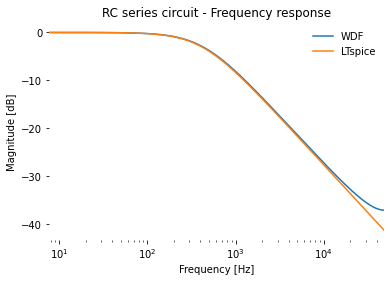

In [322]:
# One-port parameters.
V1 = ResistiveVoltageSource(1)  # 1 Ohm resistive volt. source
C1 = Capacitor(3.5e-5)          # 0.35 uF capacitor.
R1 = Resistor(10)               # 10 Ohm resistor.

# Simulation loop.
b1, b2, b3 = 0, 0, 0
for i in steps:

    # Port resistances.
    Rp1, Rp2, Rp3 = C1.Rp, R1.Rp, V1.Rp

    # 1. Gather inputs.
    a1 = C1.get_reflected_wave(b1)
    a2 = R1.get_reflected_wave(0)
    a3 = V1.get_reflected_wave(0, input[i])  # Read input signal off voltage source.
    # 2. Wave up.
    a  = (a1, a2, a3)
    Rp = (Rp1, Rp2, Rp3)
    
    # 3. Root element / 4. Wave down.
    b1, b2, b3 = series_adaptor(a, Rp)

    # 5. Gather outputs.
    output[i] = C1.wave_to_voltage()  # Output is voltage over C1.
    C1.set_incident_wave(b1)          # Store new input inside Capacitor.

    # capacitor resistance change due to tolerance
    # C1.updateRp(i)



# Plot frequency response of the WDF simulation.
plot_freqz(output, title="RC series circuit - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("/Users/gusanthon/Downloads/wave_digital_notebook-master/data/series_RC.txt", title="Frequency response", out_label='V(vout)')

# Show the Frequency response
plt.legend(**legend_style)
plt.show()


/var/folders/f3/xh405jz12hs55vqqmw2zl79w0000gn/T/ipykernel_18775/1956726997.py:27: RuntimeWarning: divide by zero encountered in log
  logR_Is_overVT = np.log(R_Is_overVT)
/var/folders/f3/xh405jz12hs55vqqmw2zl79w0000gn/T/ipykernel_18775/1282529839.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(f), np.max(f)])


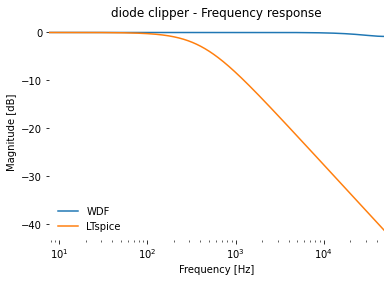

[0.00000000e+00 5.85937500e+00 1.17187500e+01 ... 4.79824219e+04
 4.79882812e+04 4.79941406e+04]


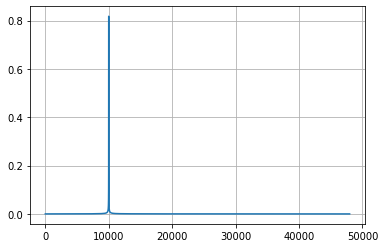

In [349]:
from scipy.fft import fft, fftfreq

# One-port parameters.
V1 = ResistiveVoltageSource(1)  # 1 Ohm resistive volt. source
C1 = Capacitor(3.5e-5)          # 0.35 uF capacitor.
R1 = Resistor(10)               # 10 Ohm resistor.
D1 = Diode(R1.Rp)

n = np.arange(0,N/FS,1/FS)
x = np.cos(2 * np.pi * 10000 * n) 
y = np.zeros(x.shape)

# Simulation loop.
b1, b2, b3 = 0, 0, 0
for i in steps:

    # Port resistances.
    Rp1, Rp2, Rp3 = D1.Rp, R1.Rp, V1.Rp
    # 1. Gather inputs.
    a1 = D1.get_reflected_wave(b1)
    a2 = R1.get_reflected_wave(0)
    # a3 = V1.get_reflected_wave(0, input[i])  # Read input signal off voltage source.
    a3 = V1.get_reflected_wave(0, x[i]) 
    # 2. Wave up.
    a  = (a1, a2, a3)
    Rp = (Rp1, Rp2, Rp3)
    
    # 3. Root element / 4. Wave down.
    b1, b2, b3 = series_adaptor(a, Rp)

    # 5. Gather outputs.
    # output[i] = D1.wave_to_voltage()  # Output is voltage over C1.
    y[i] = D1.wave_to_voltage()
    D1.set_incident_wave(b1)          # Store new input inside Capacitor.

    # capacitor resistance change due to tolerance
    # C1.updateRp(i)


# Plot frequency response of the WDF simulation.
plot_freqz(output, title= "diode clipper - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("/Users/gusanthon/Downloads/wave_digital_notebook-master/data/series_RC.txt", title="Frequency response", out_label='V(vout)')

# Show the Frequency response
plt.legend(**legend_style)
plt.show()

yf = fft(y)
xf = fftfreq(N, 1/FS)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()


### Audio examples

# Resistive voltage source in parellel with RC, RL branches

## Reference circuit
![](files/images/reference_circuit_parallel_RC_RL.png)

## WDF derivation
![](files/images/wdf_parallel_RC_RL.png)

## SPQR tree
![](files/images/spqr_parallel_RC_RL.png)

/var/folders/f3/xh405jz12hs55vqqmw2zl79w0000gn/T/ipykernel_18775/1282529839.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(f), np.max(f)])


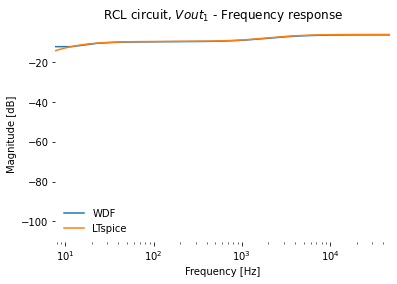

/var/folders/f3/xh405jz12hs55vqqmw2zl79w0000gn/T/ipykernel_18775/1282529839.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(f), np.max(f)])


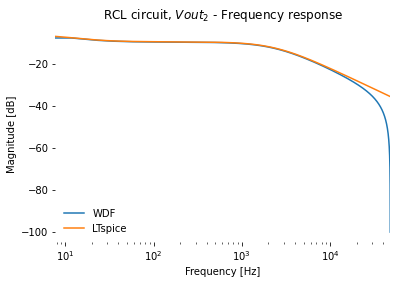

In [324]:
# Two outputs.
output_vout1 = np.zeros(input.size)
output_vout2 = np.zeros(input.size)

# One-port parameters.
V1 = ResistiveVoltageSource(10)  # Voltage source with 10 Ohm series resistor.
R2 = Resistor(10)     # 10 Ohm resistor.
R3 = Resistor(10)     # 10 Ohm resistor.
L1 = Inductor(1e-3)   # 1 mH Inductor.
C1 = Capacitor(1e-3)  # 1 mF Capacitor.

## Port resistances.

# Series port 1.
Rs11 = Rp1
Rs12 = C1.Rp
Rs13 = R2.Rp

# Series port 2.
Rs22 = R3.Rp
Rs23 = L1.Rp
Rs21 = Rs22 + Rs23  # Matched port.

# Parallel port. 
Rp2 = V1.Rp
Rp3 = Rs21
Rp1 = 1 / (1/Rp2 + 1/Rp3)  # Matched port.

# Simulation loop.
ap1,  ap2,  ap3  = 0, 0, 0
as11, as12, as13 = 0, 0, 0
as21, as22, as23 = 0, 0, 0
bs11, bs12, bs13 = 0, 0, 0
bs21, bs22, bs23 = 0, 0, 0
bp3 = 0
for i in steps:
    # 1. Gather inputs

    as22 = R3.get_reflected_wave(bs22)
    as23 = L1.get_reflected_wave(bs23)
    
    ap2 = V1.get_reflected_wave(bp3, input[i]) # Read signal from voltage source.
    
    as12 = C1.get_reflected_wave(bs12)
    as13 = R2.get_reflected_wave(bs13)
    
    # 2. Wave up
    as2 = (as21, as22, as23)
    Rs2 = (Rs21, Rs22, Rs23)
    bs21, bs22, bs23 = series_adaptor(as2, Rs2)
    
    ap3 = bs21
    ap = (ap1, ap2, ap3)
    Rp = (Rp1, Rp2, Rp3)
    bp1, bp2, bp3 = parallel_adaptor(ap, Rp)
    
    as11 = bp1
    as1 = (as11, as12, as13)
    Rs1 = (Rs11, Rs12, Rs13)
    bs11, bs12, bs13 = series_adaptor(as1, Rs1)
    
    # 3. Root / 4. Wave down.
    ap1 = bs11
    ap = (ap1, ap2, ap3)
    Rp = (Rp1, Rp2, Rp3)
    bp1, bp2, bp3 = parallel_adaptor(ap, Rp)
    
    as21 = bp3
    as2 = (as21, as22, as23)
    Rs2 = (Rs21, Rs22, Rs23)
    bs21, bs22, bs23 = series_adaptor(as2, Rs2)

    # 5. Gather outputs and store states.
    output_vout1[i] = R2.wave_to_voltage()  # Output is voltage through R2
    output_vout2[i] = R3.wave_to_voltage()  # Output is voltage through R3
    
    C1.set_incident_wave(bs12)
    L1.set_incident_wave(bs23)
    # C1.updateRp(i)

# Plot frequency response of the WDF simulation.
plot_freqz(output_vout1, title="RCL circuit, $Vout_1$ - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("/Users/gusanthon/Downloads/wave_digital_notebook-master/data/parallel_RC_RL_V(rc).txt", title="Frequency response", out_label='V(rc)')

# Show the Frequency responses
plt.legend(**legend_style)
plt.show()

# Plot frequency response of the WDF simulation.
plot_freqz(output_vout2, title="RCL circuit, $Vout_2$ - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("/Users/gusanthon/Downloads/wave_digital_notebook-master/data/parallel_RC_RL_V(rl).txt", title="Frequency response", out_label='V(rl)')

# Show the Frequency responses
plt.legend(**legend_style)
plt.show()

# LTspice files
* [Series RC circuit](files/spice/series_RC.asc)
* [Parallel RC, RL circuit](files/spice/series_RC.asc)